# Computer Vision Project

### Setup

In [5]:
%load_ext autoreload
%autoreload 2
import os
import importlib
from tqdm import tqdm

# Torch modules
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch import amp

# Custom modules
import segmentation.utils
importlib.reload(segmentation.utils)
from segmentation.utils import preprocessing, model_utils

import segmentation.dataset
importlib.reload(segmentation.dataset)
from segmentation.dataset import CVDataset
from segmentation.show import *

from models.unet_model import UNET


In [6]:
# Defining some constants that will be used throughout the notebook
DATA_DIR = 'Dataset/'
x_test_dir = os.path.join(DATA_DIR, 'Test/color')
y_test_dir = os.path.join(DATA_DIR, 'Test/label')
x_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/color')
y_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/label')

### Splitting the TrainVal data into training and validation data
* Splitting into training and validations sets is needed so we can evaluate peformance on the model while training.
* More common than K-fold cross validation in deep learning settings because of computational costs.

In [7]:
# Getting a list of relative paths to the images (x) and the masks/labels (y)
x_test_fps, y_test_fps = preprocessing.get_testing_paths(x_test_dir, y_test_dir)

# Splitting relative path names into into training and validation
x_train_fps, x_val_fps, y_train_fps, y_val_fps = preprocessing.train_val_split(x_trainVal_dir, y_trainVal_dir, 0.2)


### Custom Dataset

In [8]:
test_augmentation = preprocessing.get_validation_augmentation()
preprocessing_fn = preprocessing.get_preprocessing()
train_augmentation = preprocessing.get_training_augmentation()


train_dataset = CVDataset(x_train_fps, y_train_fps, preprocessing=preprocessing_fn, augmentation=train_augmentation)
valid_dataset = CVDataset(x_val_fps, y_val_fps)


# Printing the size of each dataset
print(f'Training dataset has size {train_dataset.__len__()}')
print(f'Validation dataset has size {valid_dataset.__len__()}')
print(f'Testing dataset has size {test_dataset.__len__()}')

Training dataset has size 2938
Validation dataset has size 735


NameError: name 'test_dataset' is not defined

In [ ]:
image, mask = train_dataset[0]

In [ ]:
image.shape

torch.Size([3, 256, 416])

In [ ]:
from models.unet_model import UNET
from segmentation.eval import *
from segmentation.eval import CVDatasetPredictions
from segmentation.metrics import *
from segmentation.pertrubations import *
from segmentation.show import *


In [ ]:
petrubaiton = CustomScaling(10)


test_dataset  = CVDataset(
                x_test_fps,
                y_test_fps,
                augmentation= test_augmentation,
                preprocessing=preprocessing_fn
                )

model = UNET()
model_utils.load_checkpoint('/Users/georgeboutselis/Downloads/best_model-dice.pth', model)
# Loading the model

eval_ds = CVDatasetPredictions(test_dataset, 'cpu')
eval_ds.set_prediction_fn(predict, model = model, device = 'cpu')

=> Loading checkpoint from /Users/georgeboutselis/Downloads/best_model-dice.pth


## Segmenation Visualisations

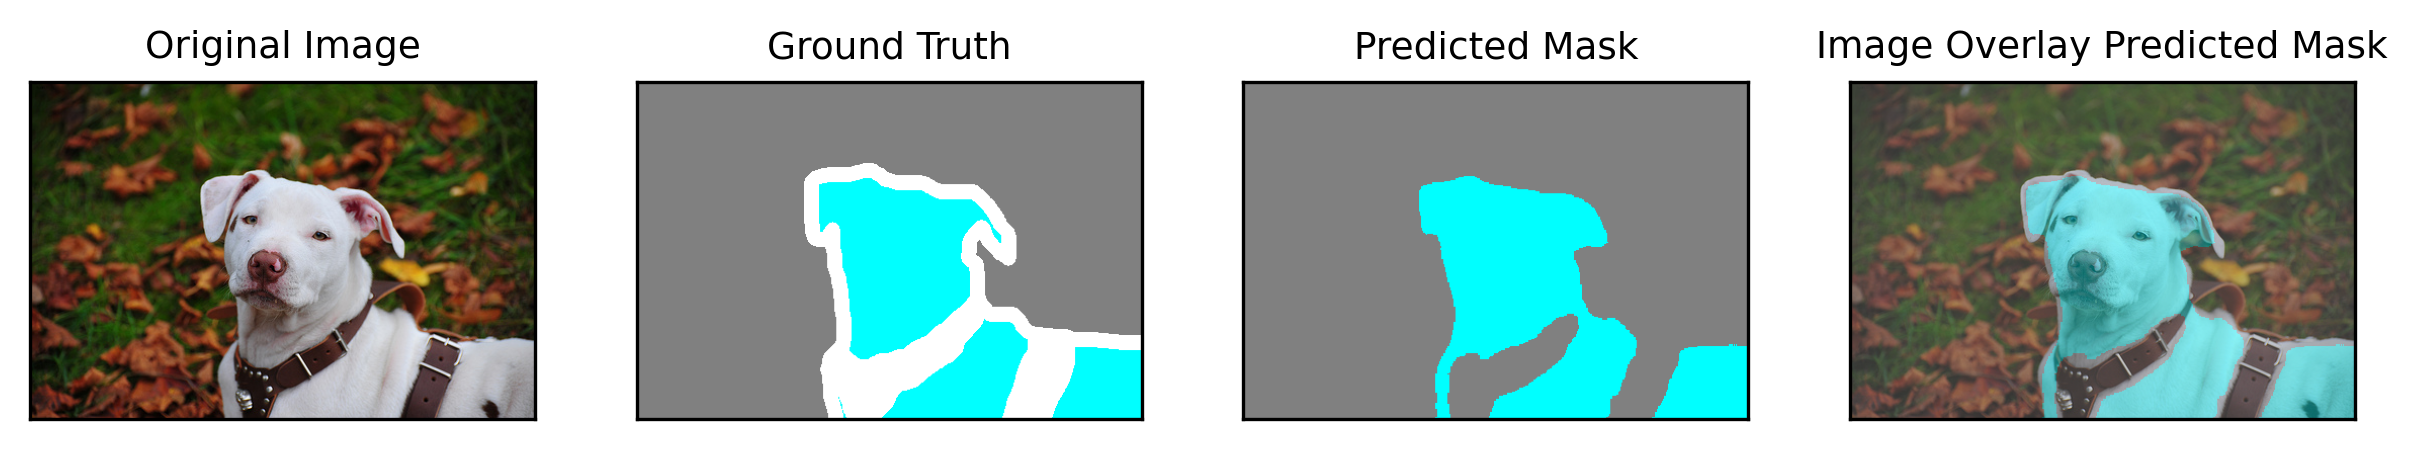

In [988]:
eval_ds.plot_segmentation(1364)

In [989]:
eval_ds.save_all_overlays()

AttributeError: 'CVDatasetPredictions' object has no attribute 'save_all_overlays'

In [ ]:
eval_ds.save_segmentation_plot(1364, folder_prefix='no_collar_unet')

AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [ ]:
image, mask =test_dataset[1]

In [990]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [991]:
df = pd.read_csv('/Users/georgeboutselis/Downloads/prompt_training.csv')
df = df.melt(id_vars=['epoch'])


renaming = {'training_loss': 'mse training loss',
            'validation_loss': 'mse validation loss',
            'mean_iou': 'mean IoU',
            'accuracy': 'accuracy',
            'dice': 'dice score',
            'epoch': 'epoch',
            'train_loss': 'CE training loss',
            'val_loss': 'CE validation loss'
            }

for id, key in renaming.items():
    df['variable'].replace(id, key, inplace= True)


/var/folders/9j/990ygjw152b6spbgwjj_qtj40000gn/T/ipykernel_68577/1545342636.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['variable'].replace(id, key, inplace= True)


In [992]:
df

epoch          variable     value
0         1  CE training loss  0.670117
1         2  CE training loss  0.648202
2         3  CE training loss  0.645782
3         4  CE training loss  0.641588
4         5  CE training loss  0.640718
...     ...               ...       ...
2010    297        dice score  0.711250
2011    298        dice score  0.716050
2012    299        dice score  0.730040
2013    300        dice score  0.730000
2014    301        dice score  0.727580

[2015 rows x 3 columns]

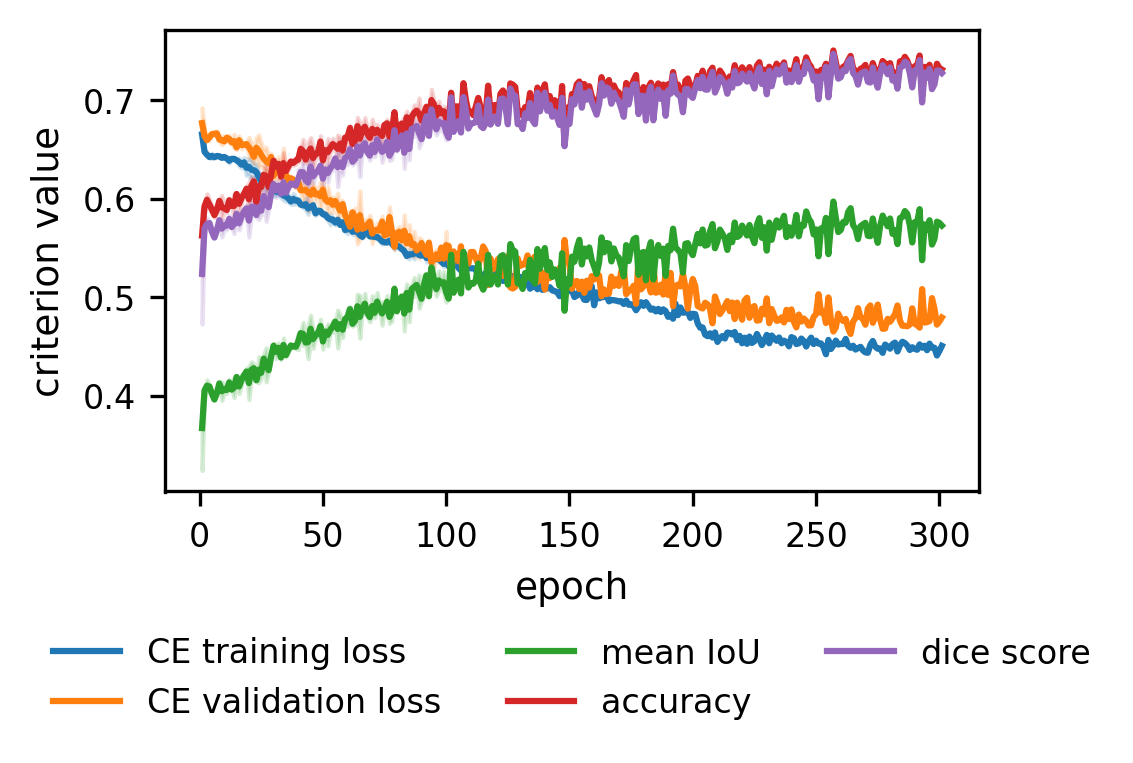

In [993]:




plt.rcParams.update({
    'font.size': 9,                # base font size
    'axes.titlesize': 9,
    'axes.labelsize': 9,           # axis labels
    'xtick.labelsize': 8,          # x tick labels
    'ytick.labelsize': 8,          # y tick labels
    'legend.fontsize': 8,
    'figure.dpi': 300              # high-res export
})



sns.lineplot(data=df, x='epoch', y='value', hue='variable')
#plt.axvline(x=150, color='red', linestyle='--', linewidth = 0.8, alpha = 0.5)

# Move legend to bottom
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
           ncol=3, frameon=False)

plt.ylabel('criterion value')

fig = plt.gcf()
fig.set_size_inches(3.5, 2)
plt.savefig("graphs/prompt_graph.pdf", bbox_inches='tight')

## Model testing 

In [994]:
import os
from segmentation.utils import preprocessing
from segmentation.dataset import CVDataset
from segmentation.eval import CVDatasetPredictions
from torch import torch
from segmentation.show import visualise_data

In [995]:
DATA_DIR = 'Dataset/'
x_test_dir = os.path.join(DATA_DIR, 'Test/color')
y_test_dir = os.path.join(DATA_DIR, 'Test/label')

# Getting a list of relative paths to the images (x) and the masks/labels (y)
x_test_fps, y_test_fps = preprocessing.get_testing_paths(x_test_dir, y_test_dir)

preprocessing_fn = preprocessing.get_preprocessing()
test_augmentation = preprocessing.get_validation_augmentation()

In [996]:
test_dataset  = CVDataset(
                x_test_fps,
                y_test_fps,
                preprocessing=preprocessing_fn,
                augmentation=test_augmentation
                )

# preprocessing is just scaling from 255 -> 1 so we need to do on testing
# valid augmentation just resizes to 256 x 416 so we also need for testing

## Your Custom prediction function! (I think you made one a while ago)

In [997]:
def predict(image, model, device="cuda" if torch.cuda.is_available() else "cpu"):
    '''
    Function that makes a predicted mask from the input image.

    # Parameters
        image: image of size (3, H, W)

    # Returns
        predicted mask of size (1, H, W)
    '''
    model.to(device)  # Ensure model is on the correct device
    model.eval()
    
    image = image.to(device)  # Move image to the same device as model

    # pred_logits from resized image (3, H, W) -> (1, 3, H, W)
    with torch.no_grad():  # Disable gradients for inference
        pred_logits = model(image.unsqueeze(0))
        pred_mask = torch.argmax(pred_logits, dim=1)

    return pred_mask

In [998]:
from models.unet_model import UNET
from segmentation.utils import model_utils
# You probably want to load your trained model here or something, depending on how youve set up your predict function
# Just loading empty one for demonstration purposes
unet_model = UNET(3, 3) 
model_utils.load_checkpoint('/Users/georgeboutselis/Downloads/best_model-2.pth', unet_model)

=> Loading checkpoint from /Users/georgeboutselis/Downloads/best_model-2.pth


In [999]:
# Initialise this
test_predictions = CVDatasetPredictions(test_dataset)

In [1000]:
# Pass in your custom prediction function
# Remember, when we use set_prediction_fn, we can specifiy the other arguments of our custom prediction function here
# For instance, I have set device = 'mps' because I have device argument in my custom prediction function
# Similar thing for model
test_predictions.set_prediction_fn(predict_fn = predict, device = 'mps', model = unet_model)

## At this point, everything is set up to make predictions

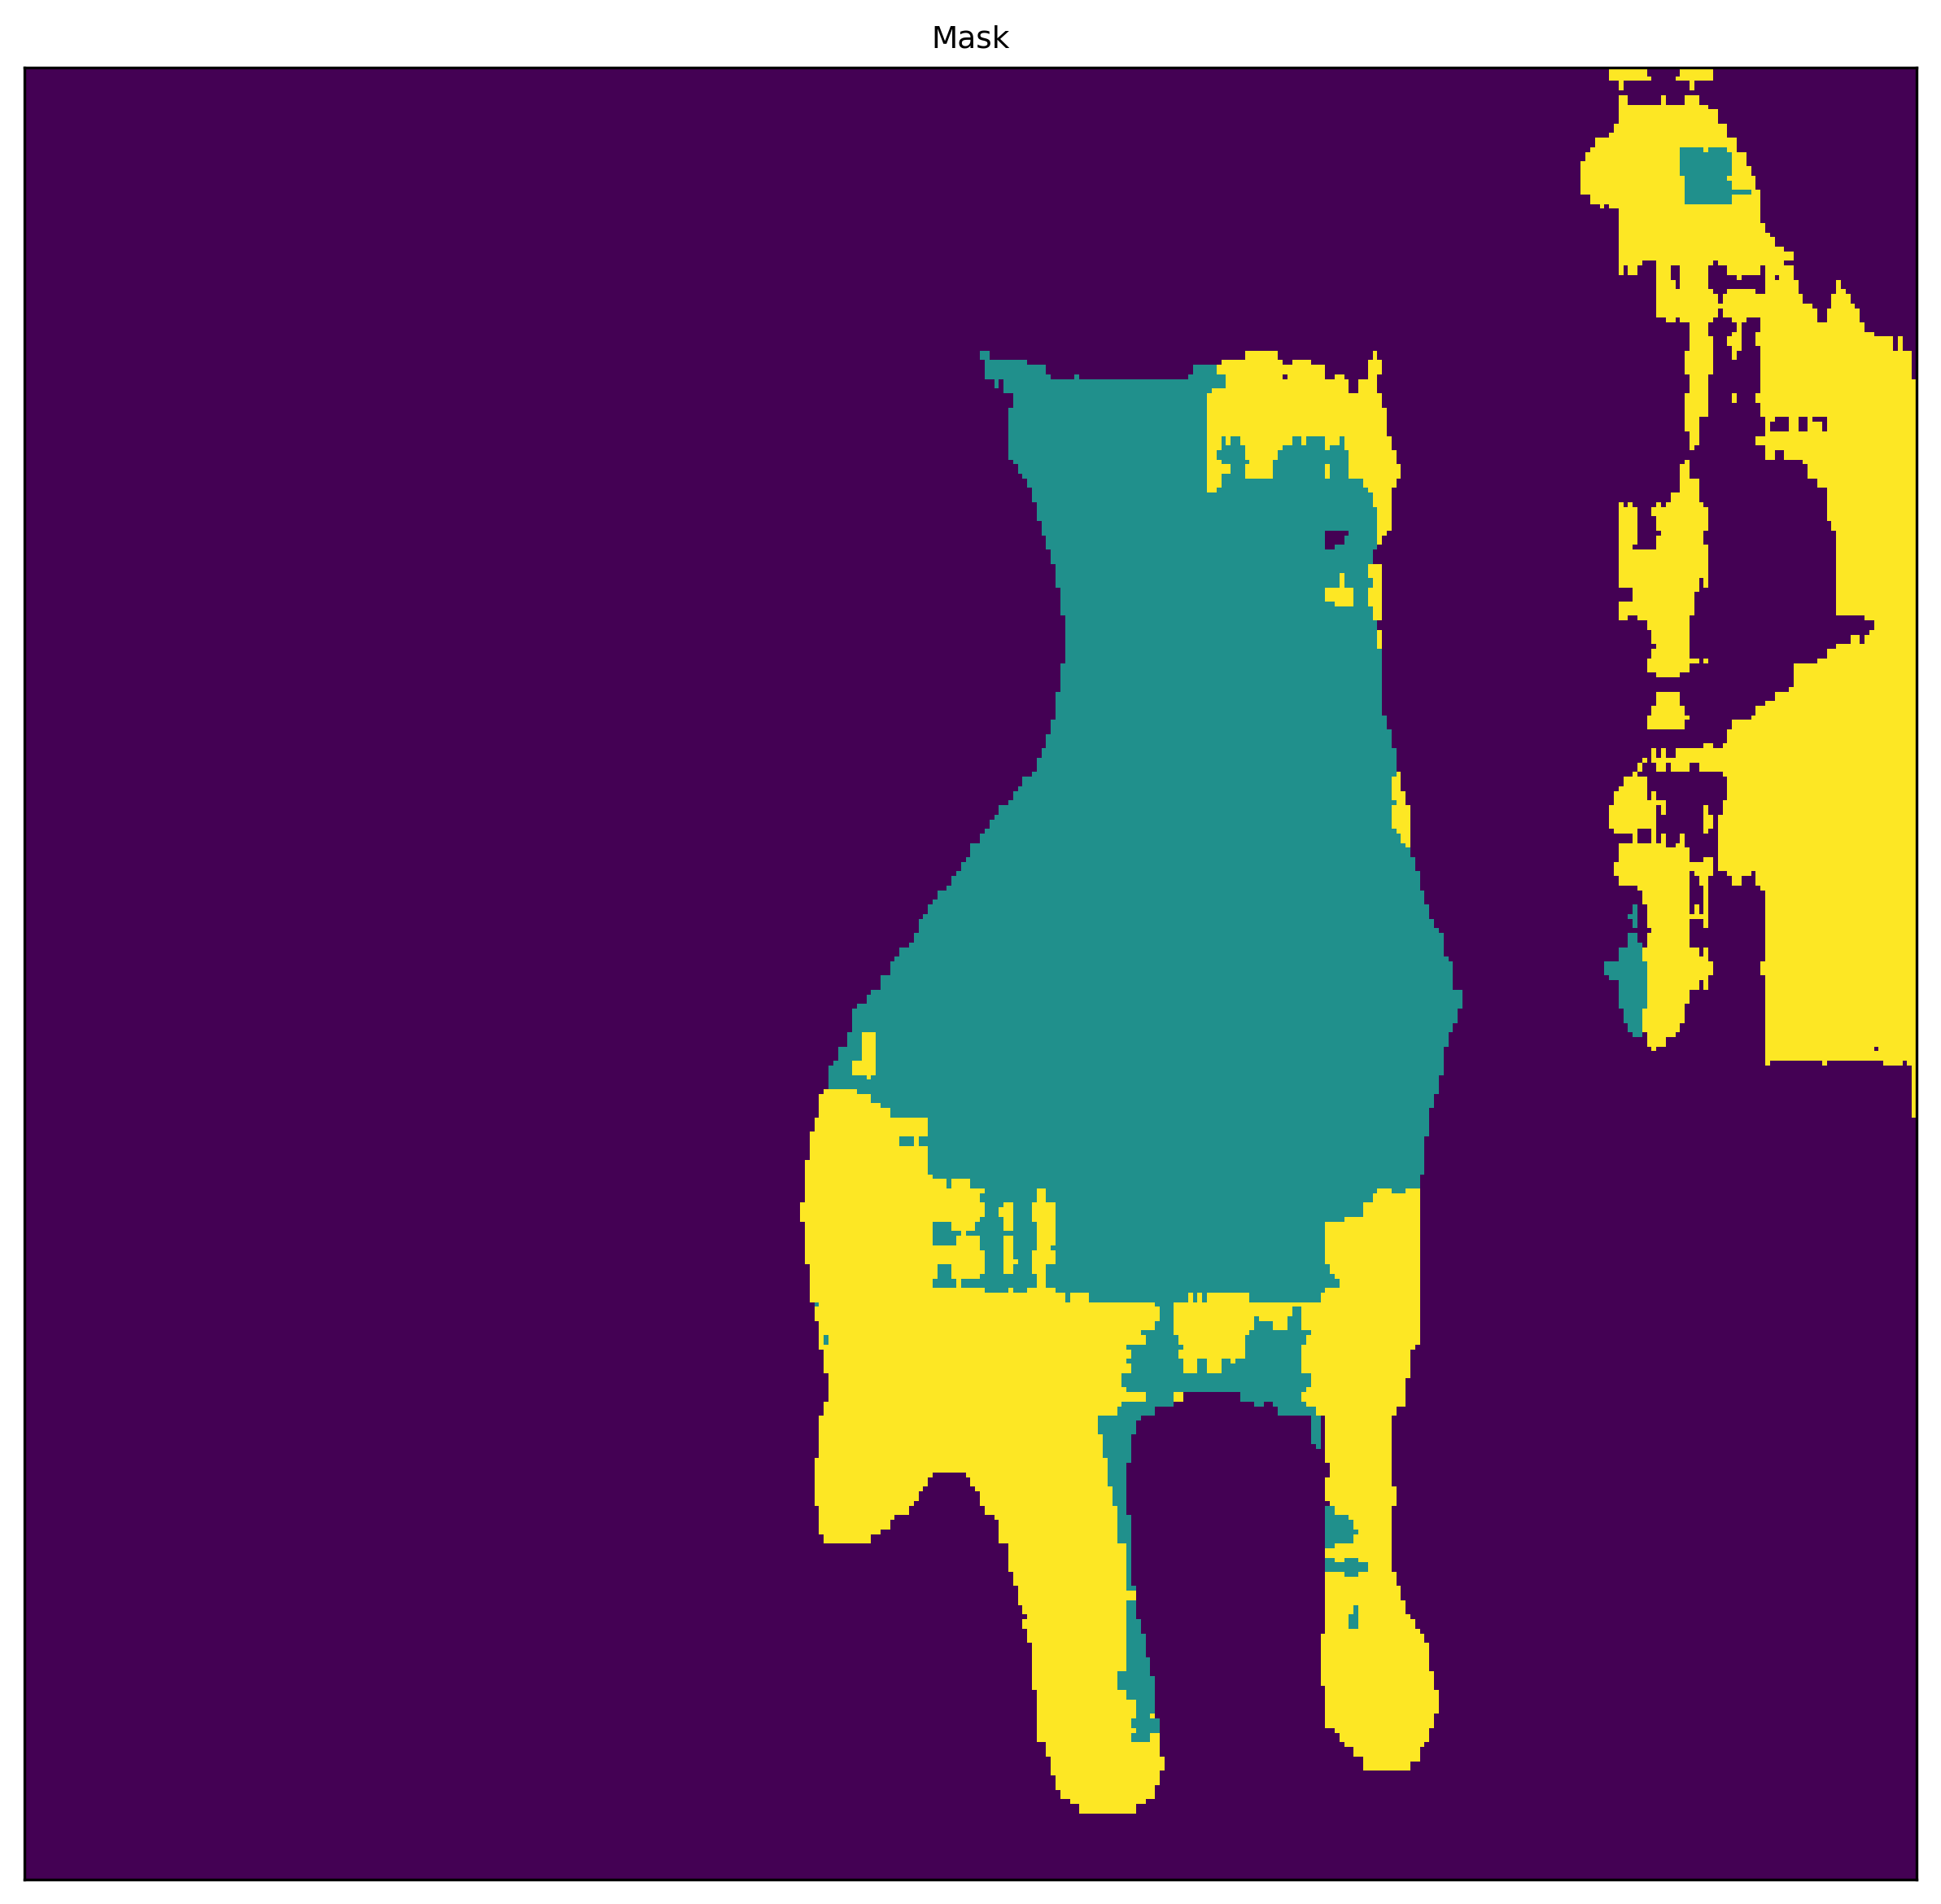

In [1001]:
# This is how you make a prediction for the 1st image in the testdataset

predicted_mask = test_predictions.predict(1) 
# Notice how this is on the original dimensions of the image now 
visualise_data(mask = predicted_mask)

## Computing metrics on the test data set on the original domain 

In [1002]:
test_predictions.mean_IoU(classes=[0, 1, 2], progress_bar=True)

IOU:   1%|          | 37/3694 [00:01<03:05, 19.76it/s]


KeyboardInterrupt: 

In [4]:
from segmentation.s3_utils import download_from_s3
download_from_s3('s3://computer-vision-state-dictionaries/unet_point_experiment_1/best_model.pth')

=> Model downloaded from S3 to best_model.pth


In [ ]:
test_predictions.compute_accuracy(ignore_class=255, progress_bar=True)

100%|██████████| 3694/3694 [03:12<00:00, 19.18it/s]


0.92992

In [ ]:
test_predictions.dice_socre(classes = [0, 1, 2], progress_bar=True)

100%|██████████| 3694/3694 [03:36<00:00, 17.10it/s]


0.88493

In [1013]:
import pandas as pd
df = pd.read_csv('/Users/georgeboutselis/Downloads/petrubation_analysis.csv')
df = df[['DICE', 'parameter', 'petrubation_name', 'parameter_name']]

In [1014]:
df

DICE  parameter       petrubation_name      parameter_name
0   0.88492       0.00         Gaussian Noise  standard deviation
1   0.88475       2.00         Gaussian Noise  standard deviation
2   0.88424       4.00         Gaussian Noise  standard deviation
3   0.88366       6.00         Gaussian Noise  standard deviation
4   0.88303       8.00         Gaussian Noise  standard deviation
..      ...        ...                    ...                 ...
75  0.83880       0.10  Salt and Pepper Noise        noise amount
76  0.83192       0.12  Salt and Pepper Noise        noise amount
77  0.82433       0.14  Salt and Pepper Noise        noise amount
78  0.81759       0.16  Salt and Pepper Noise        noise amount
79  0.81107       0.18  Salt and Pepper Noise        noise amount

[80 rows x 4 columns]

In [1015]:
df = pd.melt(df, id_vars=['petrubation_name', 'parameter_name', 'parameter'])

In [1016]:

df.replace('DICE', 'dice score', inplace = True)

In [1017]:
perturbation_groups = df.groupby(['petrubation_name', 'parameter_name'])

In [232]:
unet_point = UNET(4, 4)

In [233]:
model_utils.load_checkpoint('/Users/georgeboutselis/Downloads/best_model-3.pth', unet_point)

=> Loading checkpoint from /Users/georgeboutselis/Downloads/best_model-3.pth


In [234]:
test_input, mask = val_dataset[2]
test_output = unet_point(test_input.float())

ValueError: expected 4D input (got 3D input)

In [824]:
from petrubation_analysis import *

# Set paths and preprocessing
DATA_DIR = 'Dataset'
x_test_dir = os.path.join(DATA_DIR, 'Test/color')
y_test_dir = os.path.join(DATA_DIR, 'Test/label')

x_test_fps, y_test_fps = preprocessing.get_testing_paths(x_test_dir, y_test_dir)
preprocessing_fn = preprocessing.get_preprocessing()

# Load model
unet_model = UNET(3, 3)
model_utils.load_checkpoint('/Users/georgeboutselis/Downloads/best_model-2.pth', unet_model)

# Get all perturbation configurations
perturbation_configs = get_perturbation_configs()
petrubation_transform = petrubation_configs[0].transform
peturbation = petrubation_transform(sigma = 18)

=> Loading checkpoint from /Users/georgeboutselis/Downloads/best_model-2.pth


In [854]:
test_dataset = CVDataset(
            x_test_fps,
            y_test_fps
        )

In [855]:
eval_ds = CVDatasetPredictions(test_dataset, 'cpu')
eval_ds.set_prediction_fn(predict, device = 'cpu', model = unet_model)

In [856]:
from petrubation_analysis import *

In [966]:
peturbation = CustomGaussianNoise(sigma= 18)
peturbation = CustomGaussianBlurring(iterations=9)
peturbation = CustomScaling(factor = 1.25)
peturbation = CustomScaling(factor = 0.1)
peturbation = CustomBrightness(factor = 45)
peturbation = CustomDecreaseBrightness(factor = 45)
peturbation = CustomOcclusion(size = 45)
peturbation = CustomSaltAndPepperNoise(noise_level=0.18)

In [968]:
image, mask = test_dataset[416]
petrub_image = peturbation(image = image)['image']

In [969]:
image

array([[[113, 106,  90],
        [124, 117, 101],
        [134, 127, 109],
        ...,
        [136, 116, 117],
        [151, 131, 132],
        [157, 137, 138]],

       [[115, 108,  92],
        [128, 121, 105],
        [130, 123, 105],
        ...,
        [139, 119, 120],
        [149, 129, 130],
        [152, 132, 133]],

       [[121, 114,  98],
        [127, 120, 104],
        [134, 127, 109],
        ...,
        [146, 124, 126],
        [155, 133, 135],
        [150, 128, 130]],

       ...,

       [[121, 121, 121],
        [128, 128, 128],
        [133, 133, 131],
        ...,
        [106, 105, 110],
        [ 91,  91,  91],
        [ 88,  88,  86]],

       [[132, 134, 133],
        [127, 129, 128],
        [116, 116, 116],
        ...,
        [ 85,  84,  90],
        [ 83,  82,  87],
        [ 93,  93,  95]],

       [[161, 163, 162],
        [153, 155, 154],
        [130, 130, 130],
        ...,
        [ 90,  89,  95],
        [ 88,  87,  92],
        [ 98,  98, 100]]

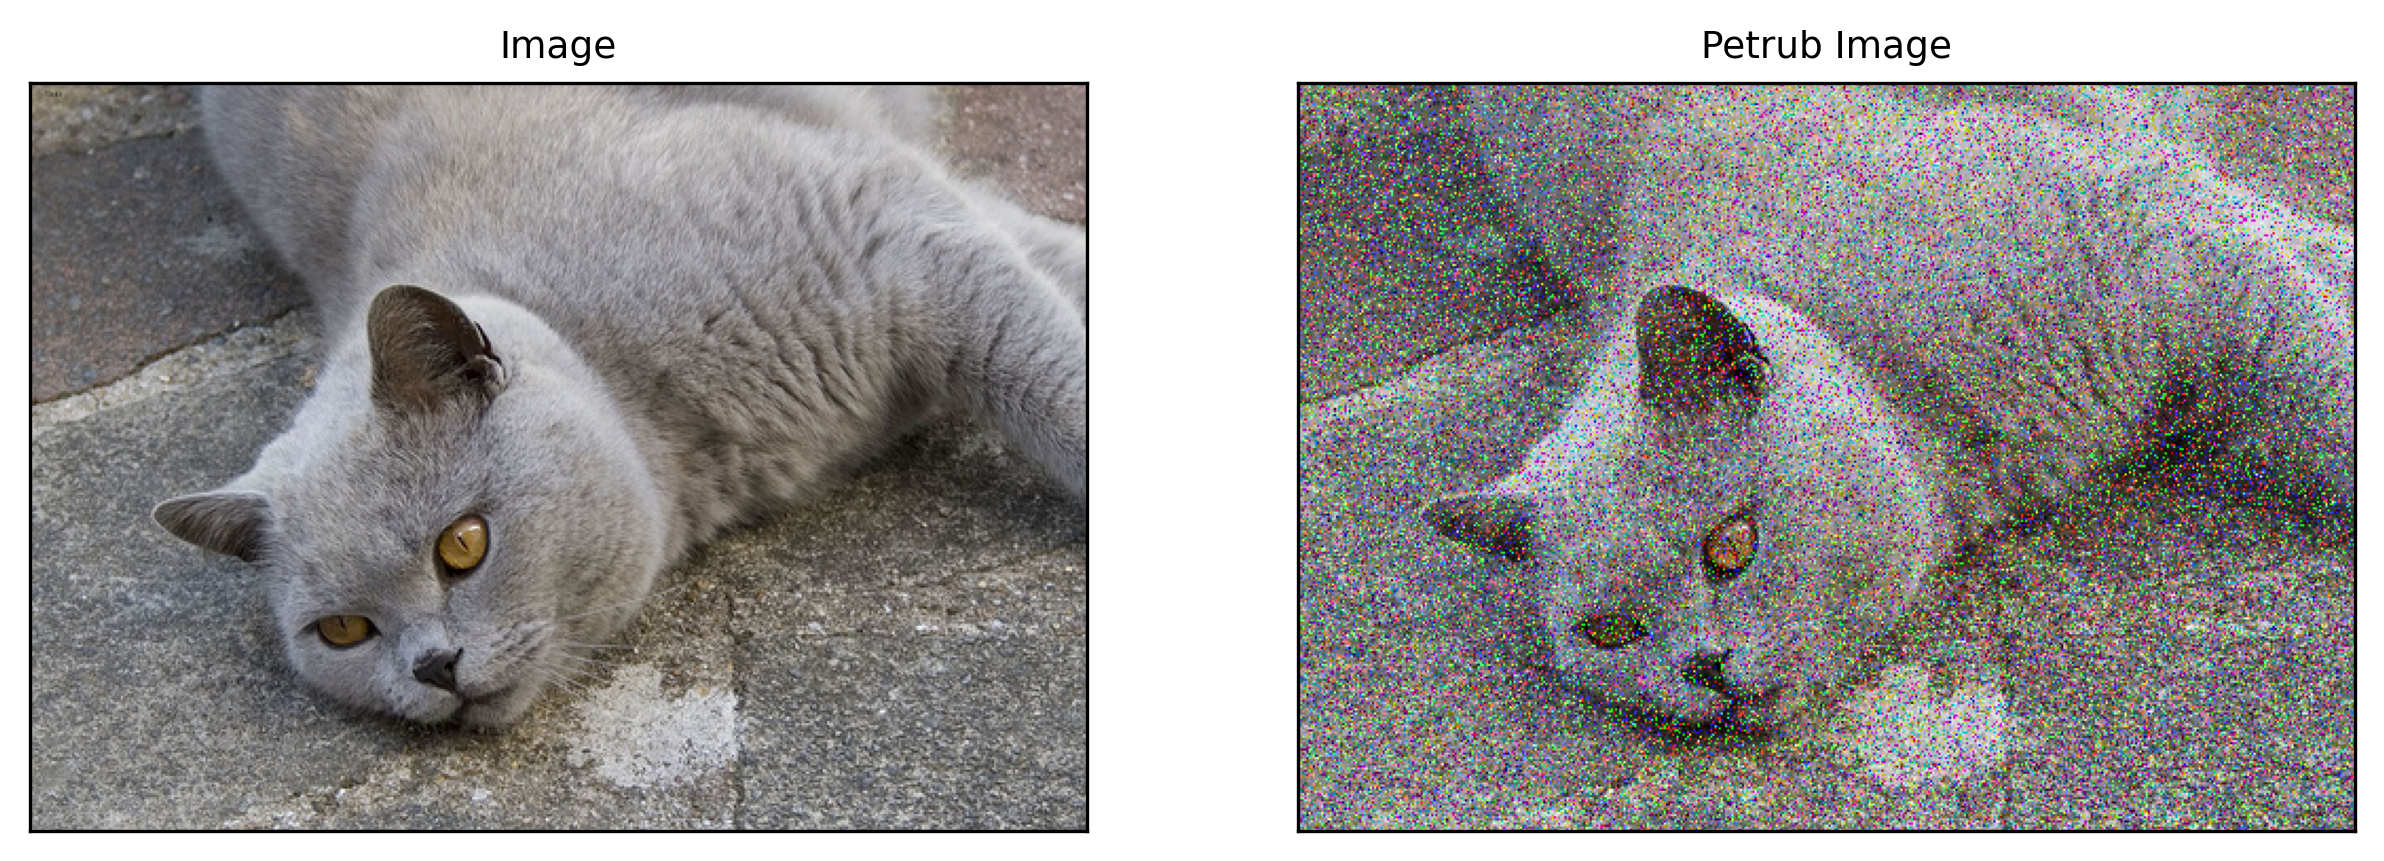

In [970]:
visualise_data(image = image, petrub_image = petrub_image)

In [971]:
peturbation_name = 'SaltAndPepper'
os.makedirs(f'segmentation_plots/{peturbation_name}')
plt.imsave(f'segmentation_plots/{peturbation_name}/image.png', image)
plt.imsave(f'segmentation_plots/{peturbation_name}/peturb.png', petrub_image)

# 

In [9]:
import pandas as pd

In [18]:
pd.read_csv('/Users/georgeboutselis/Downloads/point-based.csv').melt().groupby('variable').agg(['mean', 'std'])

value          
              mean       std
variable                    
accuracy  0.572958  0.004077
dice      0.443461  0.012990
mean_iou  0.442824  0.007142